In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report

In [4]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/test"

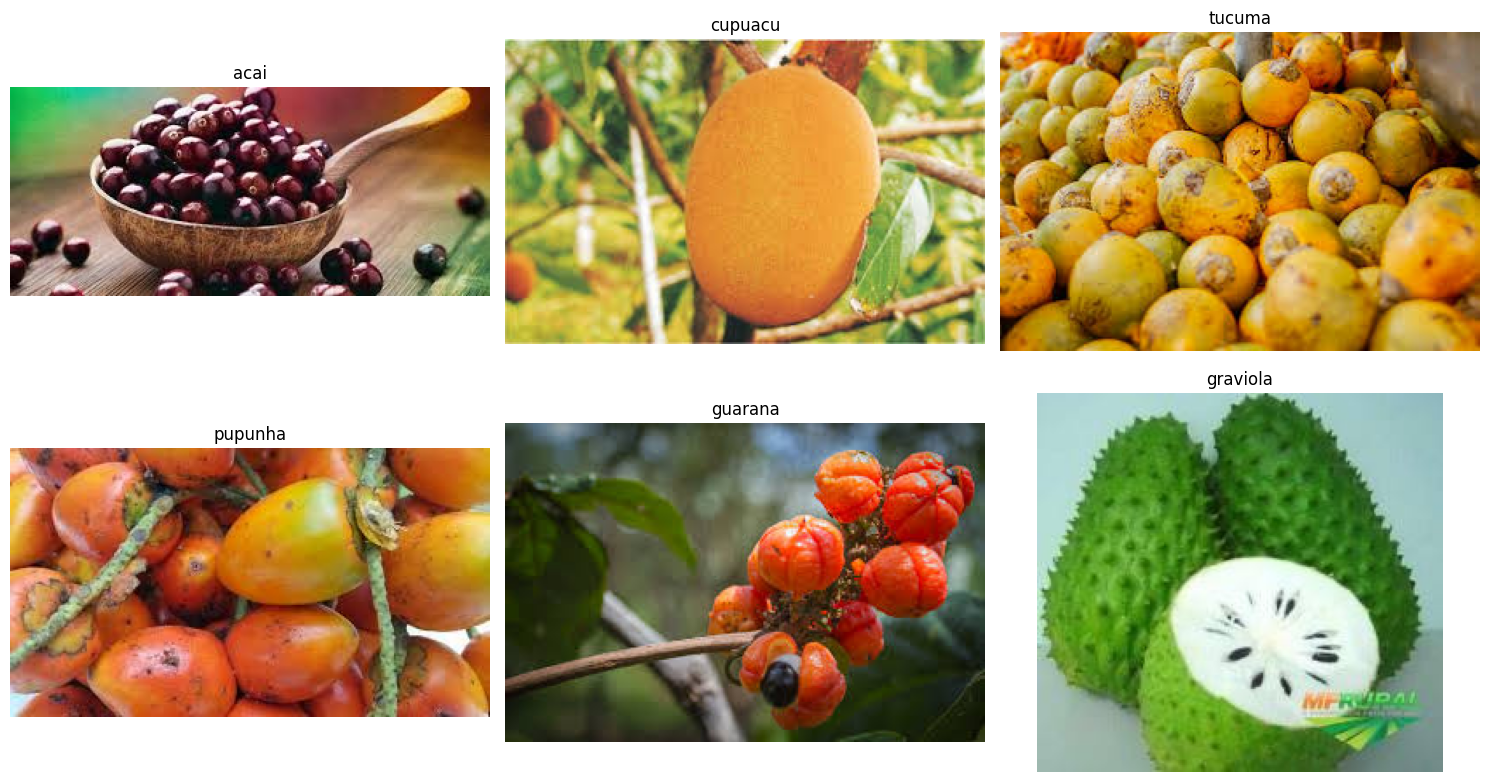

In [5]:
import random
def load_and_visualize_images(train):
    selected_images = []
    class_labels = []
    for class_dir in [d for d in os.listdir(train) if os.path.isdir(os.path.join(train, d))]:
        class_path = os.path.join(train, class_dir)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        if images:
            random_image = random.choice(images)
            selected_images.append(os.path.join(class_path, random_image))
            class_labels.append(class_dir)
    num_images = len(selected_images)
    cols = (num_images + 1) // 2

    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(15, 8))
    axes = axes.flatten()
    for i, img_path in enumerate(selected_images):
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(class_labels[i])
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

load_and_visualize_images(train_dir)


i observed that the image size of tucuma fruit is much bigger in size in comparison to the other images whereas The image size of graviola fruit is much longer in length compared to other images

In [6]:
def check_and_remove_corrupted_images(train):
    corrupted_images = []
    for class_dir in [d for d in os.listdir(train) if os.path.isdir(os.path.join(train, d))]:
        class_path = os.path.join(train, class_dir)

        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        for image_file in images:
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                os.remove(image_path)
                corrupted_images.append(image_path)
                print(f"Removed corrupted image: {image_path}")
    if not corrupted_images:
        print("No Corrupted Images Found.")
check_and_remove_corrupted_images(train_dir)


No Corrupted Images Found.


In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123,
    color_mode='rgb'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123,
    color_mode='rgb'
)
class_names = train_ds.class_names
print("Class Names:", class_names)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Class Names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", strides=1, input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", strides=1),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="softmax")
])
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=250, batch_size=16, callbacks=callbacks)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2060 - loss: 2.0141

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - accuracy: 0.1997 - loss: 2.0479 - val_accuracy: 0.0000e+00 - val_loss: 2.0989
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.2141 - loss: 1.7960

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 524ms/step - accuracy: 0.2196 - loss: 1.7879 - val_accuracy: 0.0000e+00 - val_loss: 1.8328
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2442 - loss: 1.7395

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.2491 - loss: 1.7390 - val_accuracy: 0.4444 - val_loss: 1.6416
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.2749 - loss: 1.6293

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - accuracy: 0.2756 - loss: 1.6269 - val_accuracy: 0.6667 - val_loss: 1.5440
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 831ms/step - accuracy: 0.5521 - loss: 1.4319 - val_accuracy: 0.0556 - val_loss: 1.5962
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step - accuracy: 0.4983 - loss: 1.2650 - val_accuracy: 0.1667 - val_loss: 1.6807
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.6852 - loss: 1.0133

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 582ms/step - accuracy: 0.6840 - loss: 1.0179 - val_accuracy: 0.3889 - val_loss: 1.4529
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8108 - loss: 0.7854

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.8060 - loss: 0.7880 - val_accuracy: 0.7222 - val_loss: 0.9164
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9057 - loss: 0.4832

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - accuracy: 0.9015 - loss: 0.4949 - val_accuracy: 0.7778 - val_loss: 0.7675
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9103 - loss: 0.3990

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 866ms/step - accuracy: 0.9084 - loss: 0.3987 - val_accuracy: 0.8333 - val_loss: 0.5260
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 473ms/step - accuracy: 0.9518 - loss: 0.2400 - val_accuracy: 0.7778 - val_loss: 0.6832
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9797 - loss: 0.1997

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - accuracy: 0.9813 - loss: 0.1935 - val_accuracy: 0.8333 - val_loss: 0.3921
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 572ms/step - accuracy: 0.9783 - loss: 0.1067 - val_accuracy: 0.8333 - val_loss: 0.4018
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.9891 - loss: 0.0617 - val_accuracy: 0.7778 - val_loss: 0.7021
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9797 - loss: 0.0533

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step - accuracy: 0.9813 - loss: 0.0519 - val_accuracy: 0.8333 - val_loss: 0.3264
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 1.0000 - loss: 0.0179

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 861ms/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.9444 - val_loss: 0.2970
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 1.0000 - loss: 0.0401 - val_accuracy: 0.8333 - val_loss: 0.6002
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 0.8333 - val_loss: 0.8870
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 750ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.8333 - val_loss: 0.5196
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 785ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.8889 - val_loss: 0.4307
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.8889 - val_loss: 0.3668
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.8889 - val_loss: 0.3518


In [11]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Validation Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9444 - loss: 0.2970
Test Accuracy: 0.9444
Validation Loss: 0.2970


In [12]:
model.save("Bhupen.h5")
loaded_model= tf.keras.models.load_model("Bhupen.h5")

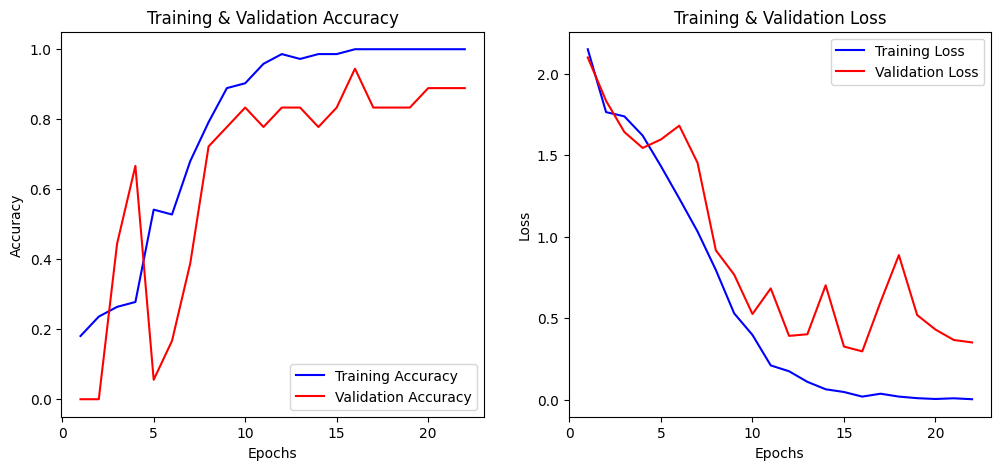

In [13]:
def plot_loss_accuracy(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

plot_loss_accuracy(history)

In [16]:
print("Unique class labels in validation dataset:", np.unique(val_labels))
print("Expected class names:", class_names)

Unique class labels in validation dataset: [4 5]
Expected class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [15]:
def get_dataset_arrays(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

val_images, val_labels = get_dataset_arrays(val_ds)

pred_probs = model.predict(val_images)
pred_labels = np.argmax(pred_probs, axis=1)

unique_labels = np.unique(val_labels)

target_names = [class_names[i] for i in unique_labels]

report = classification_report(val_labels, pred_labels, target_names=target_names, labels=unique_labels)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Classification Report:
               precision    recall  f1-score   support

     pupunha       1.00      0.67      0.80         3
      tucuma       0.94      1.00      0.97        15

    accuracy                           0.94        18
   macro avg       0.97      0.83      0.88        18
weighted avg       0.95      0.94      0.94        18



In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_size = (128, 128)
class_names = sorted(os.listdir(test_dir))

test_images = []
test_labels = []

for label, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image) / 255.0

        test_images.append(image)
        test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=len(class_names))

predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
Classification Report:
               precision    recall  f1-score   support

        acai       0.57      0.80      0.67         5
     cupuacu       0.75      0.60      0.67         5
    graviola       0.67      0.80      0.73         5
     guarana       0.50      0.20      0.29         5
     pupunha       0.50      0.20      0.29         5
      tucuma       0.33      0.60      0.43         5

    accuracy                           0.53        30
   macro avg       0.55      0.53      0.51        30
weighted avg       0.55      0.53      0.51        30

